<a href="https://colab.research.google.com/github/kad99kev/Image-Inpainting/blob/main/VanillaAutoEncoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Dependencies

In [ ]:
!pip install wandb

     |████████████████████████████████| 1.7MB 2.6MB/s 
     |████████████████████████████████| 163kB 15.9MB/s 
     |████████████████████████████████| 102kB 8.5MB/s 
     |████████████████████████████████| 122kB 17.5MB/s 
     |████████████████████████████████| 102kB 8.1MB/s 
     |████████████████████████████████| 71kB 8.2MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=606ef8d30723523e0f67da46ebfd15d5eeec72c0a540b1655c03024cc15fd6da
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for watchdog: filename=watchdog-0.10.3-cp36-none-any.whl size=73873 sha256=2eb8e4a12998a71c69b2d1726ac9c08cde14a1c859fe0a88d2bec23733f7543e
  Stored in directory: /root/.cache/pip/wheels/a8/1d/38/2c19bb311f67cc7b4d07a2ec5ea36ab1a0a0ea50db994a5bc7
  Created wheel for pathtools: filename=pathtools-0.1.2-cp36-none-any.whl size=8785 sha256=190fdd4127c447bb94c25343040a6b2aaf4f48af2271f5

# Importing Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import wandb
import cv2
from tqdm.notebook import tqdm

# Initialize Constants

In [ ]:
image_dims = (32, 32)
batch_size = 32
n_channels = 3
epochs = 20

In [ ]:
config = {
    'epochs': 20,
    'image_dims': image_dims,
    'n_channels': n_channels,
    'batch_size': batch_size
}
wandb.init(entity='kad99kev', project='inpainting', name='vanilla_autoencoder', config=config)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
def show_grid(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# Prepare Dataset

In [ ]:
class Cifar(torchvision.datasets.CIFAR10):
    def __init__(self, path, image_dims=(32, 32), n_channels=3, train=True):
        super().__init__(path, train, download=True)
        self.n_classes = 10
        self.image_dims = image_dims
        self.n_channels = n_channels
        self.resize = transforms.Resize(image_dims)
        self.to_tensor = transforms.ToTensor()

    def __getitem__(self, index):
        image, label = super().__getitem__(index)

        y_output = self.resize(image)
        X_input = self.__create_mask(y_output)
        return self.to_tensor(X_input), self.to_tensor(y_output)

    def __create_mask(self, image):
        mask = np.full((self.image_dims[0], self.image_dims[1], self.n_channels), 255, dtype=np.uint8)

        for _ in range(np.random.randint(1, 10)):
            x1, x2 = np.random.randint(1, self.image_dims[0]), np.random.randint(1, self.image_dims[0])

            y1, y2 = np.random.randint(1, self.image_dims[1]), np.random.randint(1, self.image_dims[1])

            thickness = np.random.randint(1, 3)

            cv2.line(mask, (x1, y1), (x2, y2), (1, 1, 1), thickness)

        image = np.asarray(image)
        masked_image = cv2.bitwise_and(image, mask)
        return masked_image

In [ ]:
train_dataset = Cifar('./root', image_dims)
test_dataset = Cifar('./root', image_dims, train=False)

Extracting ./root/cifar-10-python.tar.gz to ./root
Files already downloaded and verified


In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)

## Testing DataLoader Output

In [ ]:
train_dataiter = iter(train_dataloader)

In [ ]:
x_in, y_out = train_dataiter.next()
print(x_in.shape, y_out.shape)

torch.Size([32, 3, 32, 32]) torch.Size([32, 3, 32, 32])


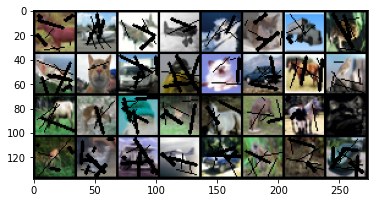

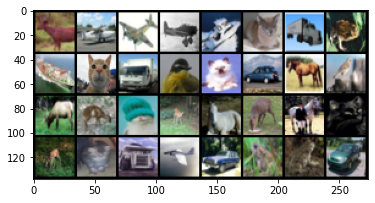

In [ ]:
show_grid(torchvision.utils.make_grid(x_in))
show_grid(torchvision.utils.make_grid(y_out))

# AutoEncoder - Decoder Model

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_filters, out_filters, kernel_size, pool_size, activation, pool_layer=True):
        super(ConvBlock, self).__init__()
        padding = kernel_size // 2 # To replicate tensorflow's 'same' (only works for default dilation etc.)

        self.pool_layer = pool_layer

        self.block = nn.Sequential(
            nn.Conv2d(in_filters, in_filters, kernel_size=kernel_size, padding=padding),
            activation(),
            nn.Conv2d(in_filters, out_filters, kernel_size=kernel_size, padding=padding),
            activation()
        )
        
        if pool_layer:
            self.pool = nn.MaxPool2d(pool_size)

    def forward(self, inputs):
        conv_out = self.block(inputs)
        if self.pool_layer:
            pool_out = self.pool(conv_out)
            return conv_out, pool_out
        return conv_out, None

In [ ]:
class UpConvBlock(nn.Module):
    def __init__(self, in_filters, out_filters, up_filters, kernel_size, up_kernel, up_stride, activation):
        super(UpConvBlock, self).__init__()
        padding = kernel_size // 2 # To replicate tensorflow's 'same' (only works for default dilation etc.)
        
        self.block = nn.Sequential(
            nn.Conv2d(in_filters, out_filters, kernel_size=kernel_size, padding=padding),
            activation(),
            nn.Conv2d(out_filters, out_filters, kernel_size=kernel_size, padding=padding),
            activation()
        )

        up_padding = up_kernel // 2
        self.trans_layer = nn.ConvTranspose2d(out_filters, up_filters, kernel_size=up_kernel, stride=up_stride, padding=up_padding, output_padding=1)


    def forward(self, connecting_inputs, shared_inputs):
        conv_out = self.block(connecting_inputs)
        trans_out = self.trans_layer(conv_out)
        trans_out = torch.cat([trans_out, shared_inputs], axis=1)
        return conv_out, trans_out

In [ ]:
class InpaintingModel(nn.Module):

    def __init__(self, num_channels=3, image_dims=(32, 32)):
        super(InpaintingModel, self).__init__()
        self.__prepare_model(num_channels)

    def forward(self, inputs):
        conv_out_1, pool_out_1 = self.block_1(inputs)
        conv_out_2, pool_out_2 = self.block_2(pool_out_1)
        conv_out_3, pool_out_3 = self.block_3(pool_out_2)
        conv_out_4, pool_out_4 = self.block_4(pool_out_3)
        
        conv_out_5, up_out_6 = self.up_block_5(pool_out_4, conv_out_4)
        conv_out_6, up_out_7 = self.up_block_6(up_out_6, conv_out_3)
        conv_out_7, up_out_8 = self.up_block_7(up_out_7, conv_out_2)
        conv_out_8, up_out_9 = self.up_block_8(up_out_8, conv_out_1)

        final_out, _ = self.final_conv(up_out_9)
        
        outputs = self.output_layer(final_out)

        return outputs

    def __prepare_model(self, num_channels):
        self.block_1 = ConvBlock(num_channels, 32, 3, 2, nn.ReLU)
        self.block_2 = ConvBlock(32, 64, 3, 2, nn.ReLU)
        self.block_3 = ConvBlock(64, 128, 3, 2, nn.ReLU)
        self.block_4 = ConvBlock(128, 256, 3, 2, nn.ReLU)

        self.up_block_5 = UpConvBlock(256, 512, 256, 3, 3, 2, nn.ReLU)
        self.up_block_6 = UpConvBlock(512, 256, 128, 3, 3, 2, nn.ReLU)
        self.up_block_7 = UpConvBlock(256, 128, 64, 3, 3, 2, nn.ReLU)
        self.up_block_8 = UpConvBlock(128, 64, 32, 3, 3, 2, nn.ReLU)

        self.final_conv = ConvBlock(64, 32, 3, 2, nn.ReLU)

        self.output_layer = nn.Sequential(
            nn.Conv2d(32, 3, 3, padding=1),
            nn.Sigmoid()
        )


In [ ]:
model = InpaintingModel()
model.cuda()

InpaintingModel(
  (block_1): ConvBlock(
    (block): Sequential(
      (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): ConvBlock(
    (block): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_3): ConvBlock(
    (block): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Training

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = y_true.view(-1)
    y_pred_f = y_pred.view(-1)
    intersection = torch.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (torch.sum(y_true_f + y_pred_f))

Initialize the optimizer, loss and metrics

In [ ]:
optimizer = optim.Adam(model.parameters())
loss = nn.MSELoss()
metrics = dice_coef

In [ ]:
def log_wandb(epoch, train_loss, train_dice, val_loss, val_dice, model, data_iter):
    wandb.log({'train_loss': train_loss, 'train_dice': train_dice, 'val_loss': val_loss, 'val_dice': val_dice}, step=epoch)

    sample_inputs, sample_truth = data_iter.next()
    sample_inputs = sample_inputs.cuda()
    
    with torch.no_grad():
        sample_preds = model(sample_inputs)

    def convert_to_grid(images):
        return torchvision.utils.make_grid(images.cpu())
    
    wandb.log({"images": wandb.Image(convert_to_grid(sample_inputs))}, step=epoch)
    wandb.log({"labels": wandb.Image(convert_to_grid(sample_truth))}, step=epoch)
    wandb.log({"predictions": wandb.Image(convert_to_grid(sample_preds.detach()))}, step=epoch)

In [ ]:
pbar = tqdm()

for epoch in range(epochs):

    # Train Step
    pbar.reset(total=len(train_dataloader))
    train_losses = []
    train_scores = []
    model.train()
    for i, (X_input, y_output) in enumerate(train_dataloader):

        X_input, y_output = X_input.cuda(), y_output.cuda()
        
        model.zero_grad()
        pred_output = model(X_input)
        
        batch_loss = loss(y_output, pred_output)
        train_losses.append(batch_loss)
        batch_loss.backward()
        
        optimizer.step()

        score = metrics(y_output, pred_output)
        train_scores.append(score)

        pbar.update()

    # Validation Step
    pbar.reset(total=len(test_dataloader))
    val_scores = []
    val_losses = []
    model.eval()
    with torch.no_grad():
        for i, (X_input, y_output) in enumerate(test_dataloader):

            X_input, y_output = X_input.cuda(), y_output.cuda()

            pred_output = model(X_input)
            
            batch_loss = loss(y_output, pred_output)
            val_losses.append(batch_loss)
            
            score = metrics(y_output, pred_output)
            val_scores.append(score)

            pbar.update()

    # Logging
    train_loss = sum(train_losses) / len(train_losses)
    train_dice = sum(train_scores) / len(train_scores)
    val_loss = sum(val_losses) / len(val_losses)
    val_dice = sum(val_scores) / len(val_scores)

    log_wandb(epoch + 1, train_loss, train_dice, val_loss, val_dice, model, iter(test_dataloader))

    print(f'Epoch: {epoch + 1}/{epochs}')
    print(f'Train Loss: {train_loss} - Train Dice Coeff: {train_dice}')
    print(f'Valid Loss: {val_loss} - Valid Dice Coeff: {val_dice}')

Epoch: 1/20
Train Loss: 0.006355372257530689 - Train Dice Coeff: 0.5918596386909485
Valid Loss: 0.0034862111788243055 - Valid Dice Coeff: 0.60821133852005
Epoch: 2/20
Train Loss: 0.0028753168880939484 - Train Dice Coeff: 0.5994004011154175
Valid Loss: 0.002781946212053299 - Valid Dice Coeff: 0.6067275404930115
Epoch: 3/20
Train Loss: 0.0024923449382185936 - Train Dice Coeff: 0.6003389358520508
Valid Loss: 0.0023502770345658064 - Valid Dice Coeff: 0.6042032241821289
Epoch: 4/20
Train Loss: 0.0023131833877414465 - Train Dice Coeff: 0.6007683277130127
Valid Loss: 0.0022581755183637142 - Valid Dice Coeff: 0.6038703918457031
Epoch: 5/20
Train Loss: 0.0021874483209103346 - Train Dice Coeff: 0.6010916233062744
Valid Loss: 0.0021221893839538097 - Valid Dice Coeff: 0.6046465635299683
Epoch: 6/20
Train Loss: 0.0019328418420627713 - Train Dice Coeff: 0.6016589403152466
Valid Loss: 0.001765737310051918 - Valid Dice Coeff: 0.6032558083534241
Epoch: 7/20
Train Loss: 0.0016825300408527255 - Train Dic

# Output Samples

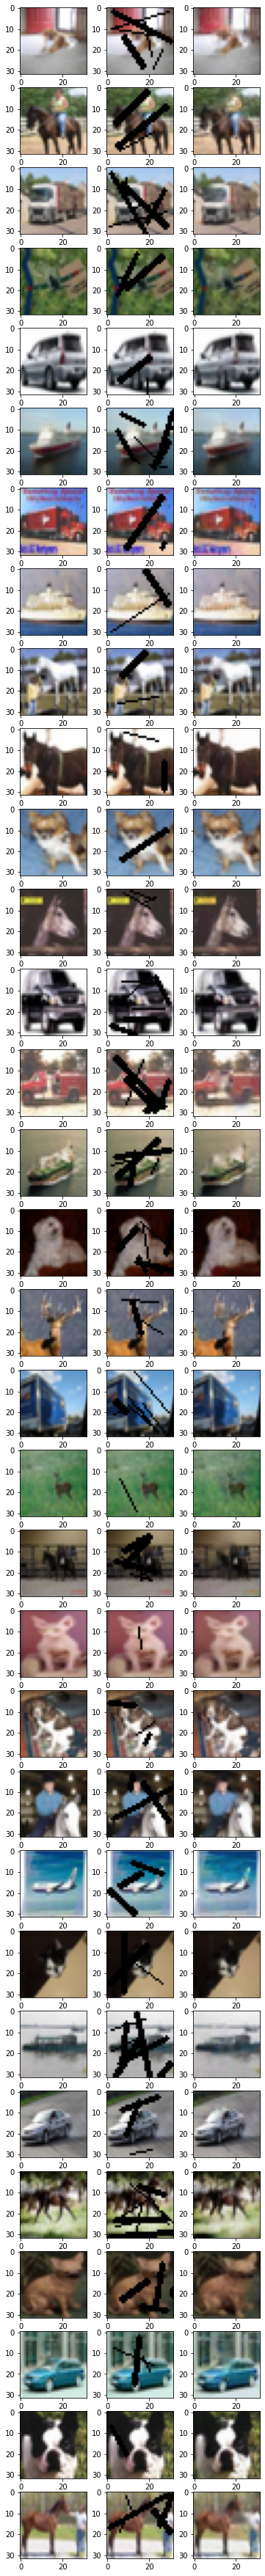

In [ ]:
sample_inputs, sample_truths = train_dataiter.next()
sample_inputs = sample_inputs.cuda()

model.eval()
with torch.no_grad():
    sample_preds = model(sample_inputs)

fig, axs = plt.subplots(nrows=32, ncols=3, figsize=(6, 2 * 32))

sample_inputs = sample_inputs.cpu()
for i in range(32):
    axs[i][0].imshow(np.transpose(sample_truths[i], (1, 2, 0)))
    axs[i][1].imshow(np.transpose(sample_inputs[i], (1, 2, 0)))
    axs[i][2].imshow(np.transpose(sample_preds[i].cpu().numpy(), (1, 2, 0)))